## Final Project Submission

Please fill out:
* Student name: Louis Bademosi
* Student pace: Full time
* Scheduled project review date/time: 
* Instructor name:
* Blog post URL:


# Project Overview

- quick overwiev of my approach to the project

# Import Data

In [188]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [189]:
''' 
Importing the data. By the project specifications I will be dropping these columns from the get go: 
date
view
sqft_above
sqft_basement
yr_renovated
zipcode
lat
long
sqft_living15
sqft_lot15 
'''

df = pd.read_csv('kc_house_data.csv')
drop_vars = ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated',
             'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

df.drop(columns=drop_vars, inplace=True)
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987


In [190]:
df.shape

(21597, 11)

# Light exploration & Cleaning

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
id             21597 non-null int64
price          21597 non-null float64
bedrooms       21597 non-null int64
bathrooms      21597 non-null float64
sqft_living    21597 non-null int64
sqft_lot       21597 non-null int64
floors         21597 non-null float64
waterfront     19221 non-null float64
condition      21597 non-null int64
grade          21597 non-null int64
yr_built       21597 non-null int64
dtypes: float64(4), int64(7)
memory usage: 1.8 MB


In [192]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,3.409825,7.657915,1970.999676
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.650546,1.173200,29.375234
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,1900.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1951.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,3.000000,7.000000,1975.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,4.000000,8.000000,1997.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,2015.000000


### Errors in the data to look for/clean:
- Correct 'waterfront' null values
- The 177 duplicates found
- Check data abides by the 3 laws of tidy data. Columns = variables, rows = single obvservations and dataframes contain a single theme of data (I can already confirm it does)
- Remove outliers based on inter quartile ranges as this data set seems to have a large amount of range in some of the variables. Using measures of dispersion about the median instead of the mean will reduce the effects of extreme results. Alternatively standard deviations could be used

In [193]:
# looking for duplicates and null values. For some reason my initial check for null value search returned negative 
# but here I've found 2376

dup = df['id'].duplicated().sum()
print(df.isnull().sum())
print(f'Number of duplicates: {dup}')

id                0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront     2376
condition         0
grade             0
yr_built          0
dtype: int64
Number of duplicates: 177


In [194]:
# 'waterfront' column contains 0 or 1's denoting yes or no for whether or not the house has a waterfront
# Expectedly most houses do not have one, so the null values will be filled with 0's

df.fillna({'waterfront': 0.0}, inplace=True)
df.isnull().sum()

id             0
price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
floors         0
waterfront     0
condition      0
grade          0
yr_built       0
dtype: int64

In [195]:
df['waterfront'].duplicated().sum()

21595

In [196]:
# duplicates wil be dropped
df.drop_duplicates(subset='id', keep='first', inplace=True)

In [197]:
# Rounding the values ending in 0.5 up, so that all floors are counted as 1 whole floor
df['floors'] = df['floors'].apply(lambda x: x+0.5 if str(x)[2] != '0' else x)

''

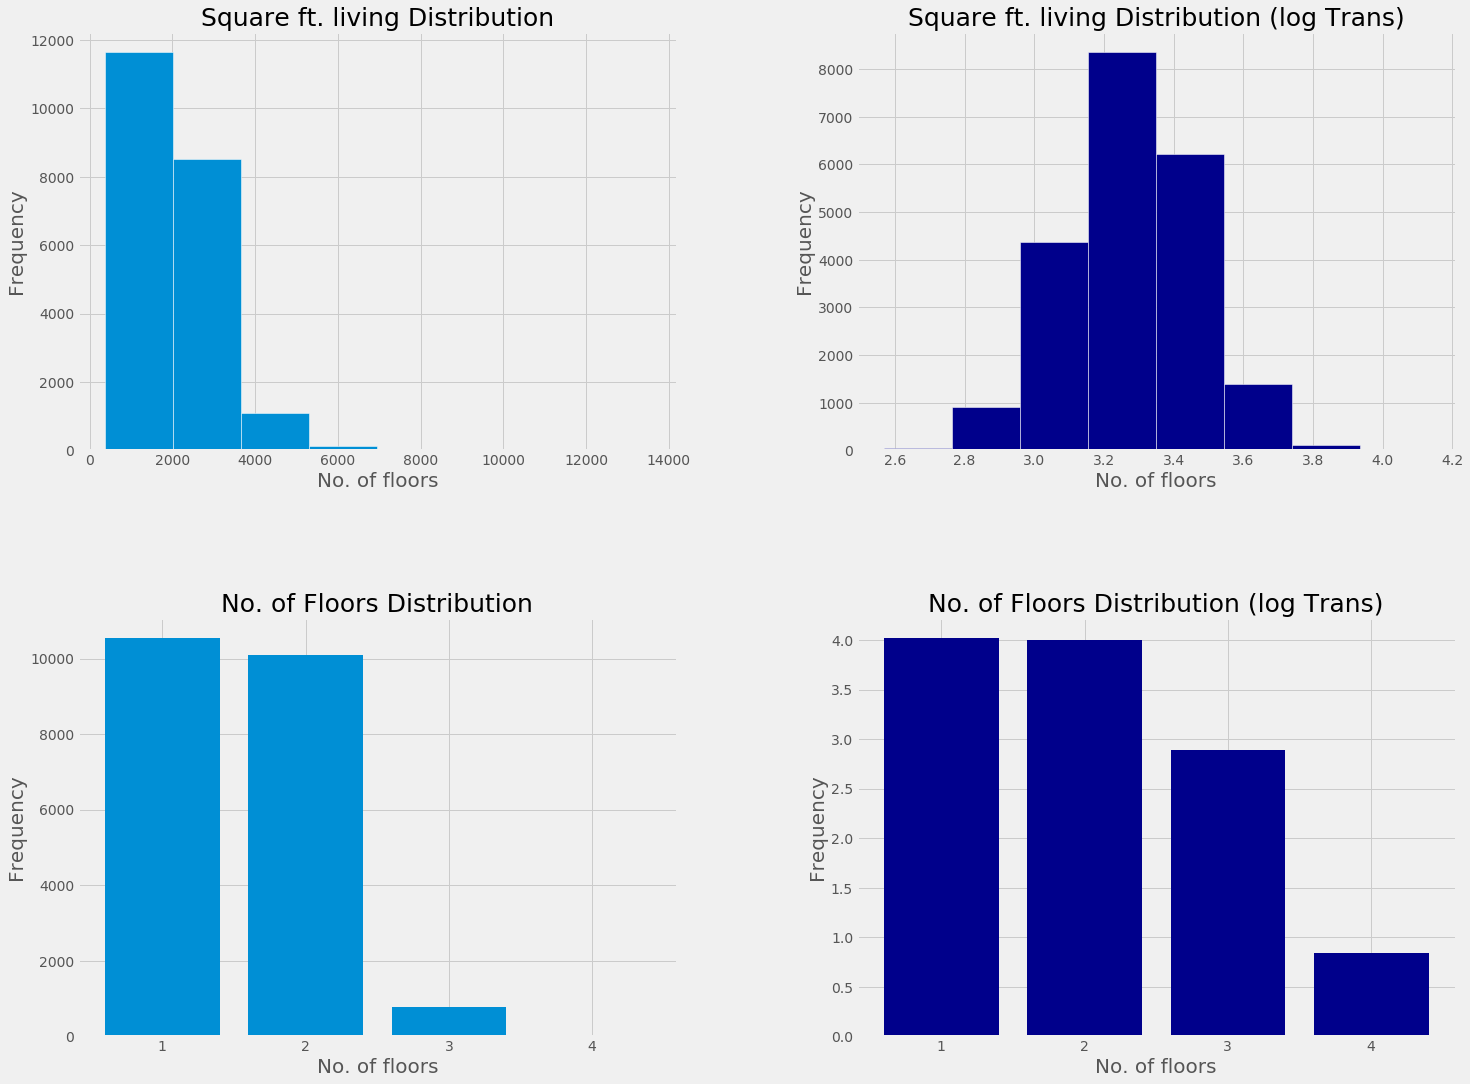

In [223]:
# Simple exploratory plots to give me an some insight into the data. Also a chance to experiment with transformations

fig, axs = plt.subplots(2, 2, figsize=(22,15))
fig.subplots_adjust(wspace=0.3, hspace=0.4, top=1)
val_counts = {}
for i in df['floors']:
    val_counts[i] = val_counts.get(i, 0) +1
bar_x = [x[0] for x in val_counts.items()]
bar_y = [x[1] for x in val_counts.items()]

# A frequency dist of square ft living areas
axs[0, 0].hist(df['sqft_living'], bins=8, edgecolor='white')
axs[0, 0].set_title('Square ft. living Distribution', fontsize=25)
axs[0, 0].set_xlabel('No. of floors', fontsize=20)
axs[0, 0].set_ylabel('Frequency', fontsize=20)

# A frequency dist of square ft living areas, log transformed to better be able to see the spread
# of data about the mean
axs[0, 1].hist(df['sqft_living'].transform(np.log10), bins=8, edgecolor='white', color='darkblue')
axs[0, 1].set_title('Square ft. living Distribution (log Trans)', fontsize=25)
axs[0, 1].set_xlabel('No. of floors', fontsize=20)
axs[0, 1].set_ylabel('Frequency', fontsize=20)

# A frequency distribution of the number of floors
axs[1, 0].bar(bar_x, bar_y)
axs[1, 0].set_title('No. of Floors Distribution', fontsize=25)
axs[1, 0].set_xticks(bar_x)
axs[1, 0].set_xlabel('No. of floors', fontsize=20)
axs[1, 0].set_ylabel('Frequency', fontsize=20)

# A log transformation of the y axis of the frequency distribution, such that the smaller
# differences between 3 and 4 floors are easily visible
axs[1, 1].bar(bar_x, np.log10(bar_y), color='darkblue')
axs[1, 1].set_title('No. of Floors Distribution (log Trans)', fontsize=25)
axs[1, 1].set_xticks(bar_x)
axs[1, 1].set_xlabel('No. of floors', fontsize=20)
axs[1, 1].set_ylabel('Frequency', fontsize=20)
;

In [199]:
# boxplots and outliers!!!!!!

# Feature Engineering

__Features I will create:__ <br><br>
_1. Create a psudo-volume column:_ acting as a rough estimate comparison between the size of the houses. 'sqft_livng' is the area of the house's ground floor, multiplying that by the house's height will give you its volume (roughly). The 'floors' variable is used as a rough estimation of the house's height. <br> I am interested to see how this effects the model's results. I am also expecting some form of colinearity between the 'psudo_volume' and its constituent variables <br><br>
_2. Create a total rooms column:_ as an all round representation of the number of rooms <br><br>
_3. Create an age column:_ that will calculate the age of the house based on the current year that this notebook is run in <br><br>
_4. Create a binned column:_ based on the new 'psudo-volume' variable that will take the estimated volume of the house and place it in a category of small, medium or large. Again, I am curious to see how this feature may prove usefull if at all

In [177]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1965
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1987


In [178]:
# Creating a psudo volume column which is the product of the 'floors' and 'sqft_living' variables
df['psudo_volume'] = df['floors'] * df['sqft_living']

In [179]:
# Creating a total rooms column that is a sum of the bathrooms and bedrooms in the house

df['total_rooms'] = df['bedrooms'] + df['bathrooms']

In [180]:
# Creating an age column that will be accurate to the current year

current_yr = datetime.date.today().year
df['age'] = current_yr - df['yr_built']

In [181]:
# Creating a size category column based off of the psudo-volume variable
psuvol_min = df['psudo_volume'].describe()[3]
psuvol_max = df['psudo_volume'].describe()[-1]
small = psuvol_max *0.4
medium = psuvol_max *0.5

df['size_category'] = None
for i, volume in enumerate(df['psudo_volume']):
    if volume <= small:
        df.loc[i, 'size_category'] = 'small'    
    if volume <= medium:
        df.loc[i, 'size_category'] = 'medium'      
    else:
        df.loc[i, 'size_category'] = 'large'

In [182]:
df['size_category'].value_counts()

medium    21413
large         7
Name: size_category, dtype: int64

In [183]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,psudo_volume,total_rooms,age,size_category
0,7.129301e+09,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,3.0,7.0,1955.0,1180.0,4.00,65.0,medium
1,6.414100e+09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,3.0,7.0,1951.0,5140.0,5.25,69.0,medium
2,5.631500e+09,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,3.0,6.0,1933.0,770.0,3.00,87.0,medium
3,2.487201e+09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,5.0,7.0,1965.0,1960.0,7.00,55.0,medium
4,1.954401e+09,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,3.0,8.0,1987.0,1680.0,5.00,33.0,medium


# EDA

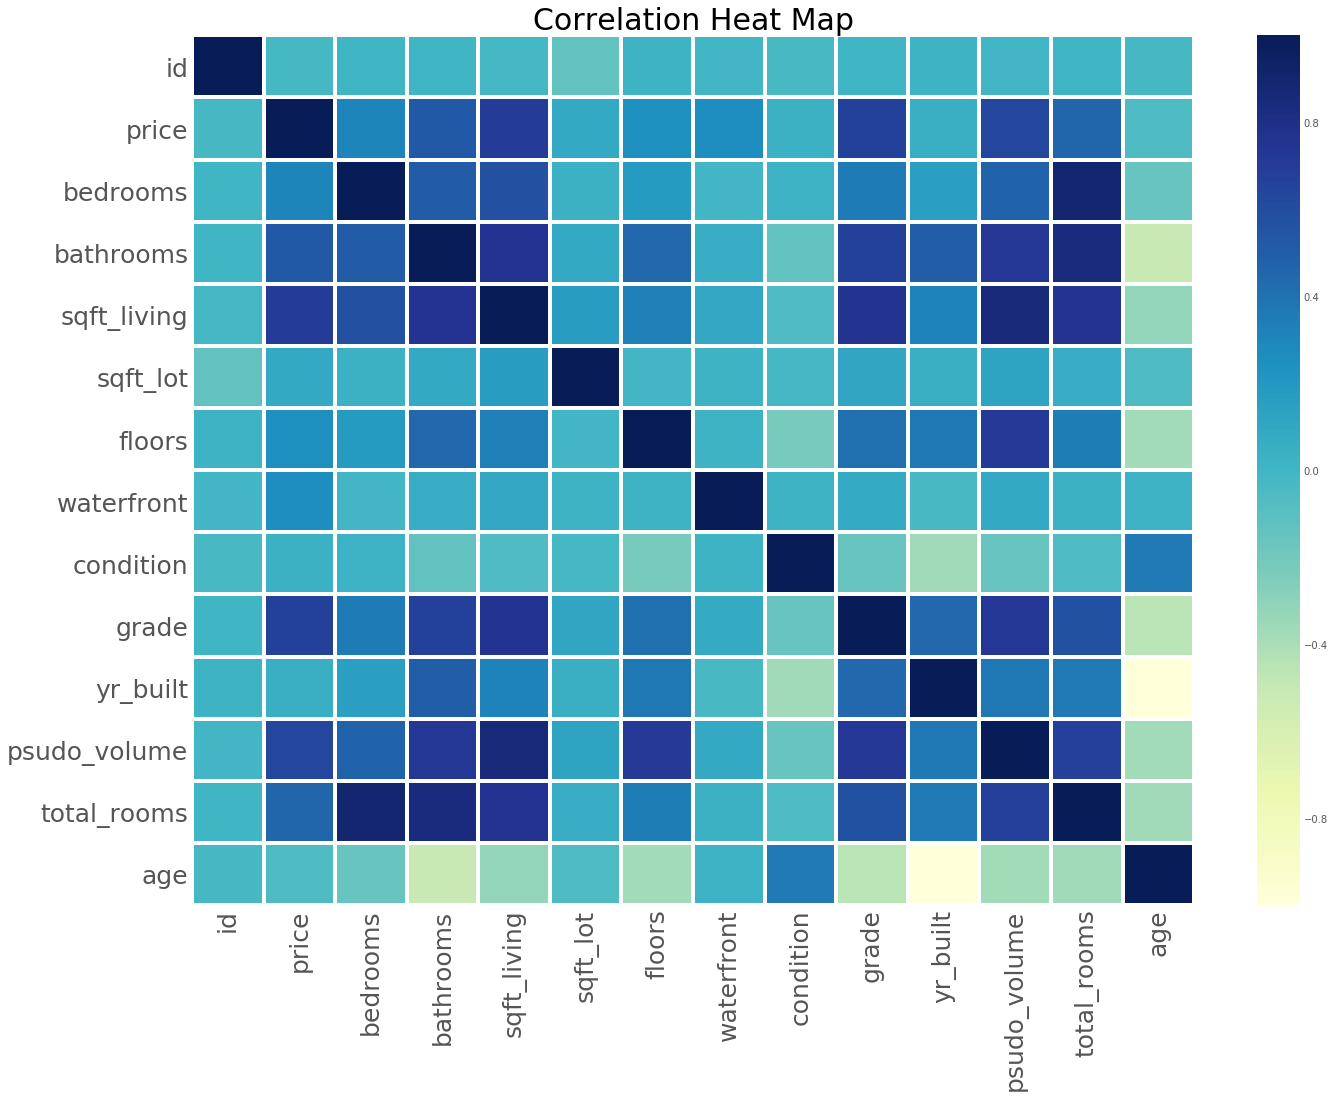

In [184]:
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(20,16))
ax.set_title('Correlation Heat Map', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
sns.heatmap(df_corr, linewidths=3, cmap="YlGnBu")
plt.show();

# Modelling

# Conclusion